In [1]:
#Import packages
import numpy as np
from keras.layers import *
from keras.models import *
from keras.datasets import mnist
from keras.optimizers import RMSprop
import keras.backend as K
import matplotlib.pyplot as plt
from functools import partial
import glob
import os

Using TensorFlow backend.


In [2]:
import tensorflow as tf

In [3]:
#Hyperparameters
batch_size = 64
iterations = 20000

#Loss tracking
d_loss = []
g_loss = []
gp_loss = []

# Set the path to the directory containing the array files
dir_path = "C:\\NetHack\\sys\\windows\\vs\\NetHackW\\levels"

x_train = []

# Set the number of rows and columns for the array
rows = 21
cols = 80

# Get a list of all files in the directory with the .bin extension
file_list = glob.glob(os.path.join(dir_path, "level_data_*.bin"))

# Loop through the file list and save each plot image as a PNG file
for file_path in file_list:
    # Read the array from the file
    arr = np.fromfile(file_path, dtype=np.uint8).reshape((rows, cols))

    # Determine the longest dimension of the rectangular image
    max_dim = 80

    # Pad the array to make it square using the last value of the array
    pad_width = ((0, max_dim - arr.shape[0]), (0, max_dim - arr.shape[1]))
    arr_padded = np.pad(arr, pad_width=pad_width, mode='constant', constant_values=arr[-1,-1])
    x_train.append(arr_padded)
    
x_train = np.array(x_train).astype('float32')

# Normalize the pixel values to the range [0, 1]
x_train /= 255.0

# Add a new dimension with size 1 at the end of x_train
x_train = np.expand_dims(x_train, axis=-1)


print(np.shape(x_train))

(10000, 80, 80, 1)


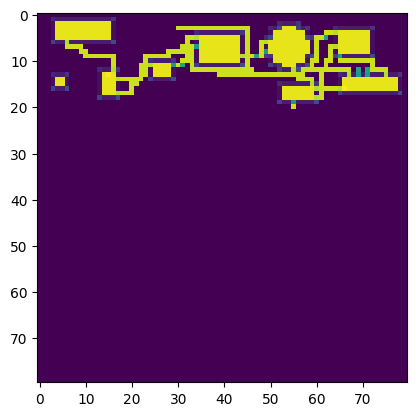

In [4]:
plt.imshow(x_train[6])

plt.show()

In [5]:
def AdaIN(x):
    #Normalize x[0]
    mean = K.mean(x[0], axis = [0, 1], keepdims = True)
    std = K.std(x[0], axis = [0, 1], keepdims = True) + 1e-7
    y = (x[0] - mean) / std
    
    #Reshape gamma and beta
    pool_shape = [-1, 1, 1, y.shape[-1]]
    g = K.reshape(x[1], pool_shape)
    b = K.reshape(x[2], pool_shape)
    
    #Multiply by x[1] (GAMMA) and add x[2] (BETA)
    return y * g + b

In [6]:
def gradient_penalty_loss(y_true, y_pred, sample, weight, sample_weight=None):
    gradients = K.gradients(y_pred, sample)[0]
    gradients_sqr = K.square(gradients)
    gradient_penalty = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))

    # (weight / 2) * ||grad||^2
    # Penalize the gradient norm
    return K.mean(gradient_penalty) * (weight / 2)

In [7]:
# Build Generator network.

# Latent input
latent = Input([100])

# Mapping
w = Dense(512, activation='relu')(latent)
w = Dense(512, activation='relu')(w)

# Small image
x = Dense(10 * 10 * 256, activation='relu')(w)
x = Reshape([10, 10, 256])(x)

# Layer = Convolution, AdaIN, Activation
# 10x10x256
gamma = Dense(128, bias_initializer='ones')(w)
beta = Dense(128)(w)

x = Conv2D(128, 4, padding='same')(x)
x = Lambda(AdaIN)([x, gamma, beta])
x = Activation('relu')(x)
x = UpSampling2D()(x)

# 20x20x128
gamma = Dense(64, bias_initializer='ones')(w)
beta = Dense(64)(w)

x = Conv2D(64, 4, padding='same')(x)
x = Lambda(AdaIN)([x, gamma, beta])
x = Activation('relu')(x)
x = UpSampling2D()(x)

# 40x40x64
gamma = Dense(32, bias_initializer='ones')(w)
beta = Dense(32)(w)

x = Conv2D(32, 4, padding='same')(x)
x = Lambda(AdaIN)([x, gamma, beta])
x = Activation('relu')(x)
x = UpSampling2D()(x)

# 80x80x32
x = Conv2D(16, 4, padding='same', activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

generator = Model(inputs=latent, outputs=x)
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          51712       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          262656      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 25600)        13132800    dense_2[0][0]                    
____________________________________________________________________________________________

In [8]:
# Build discriminator network.
discriminator = Sequential()

# Discriminator starts with an image of shape 80x80x1.
# Use convolution and pooling to extract features and make the image smaller.
discriminator.add(Conv2D(filters=16, kernel_size=4, padding='same', activation='relu', input_shape=[80, 80, 1]))
discriminator.add(AveragePooling2D())

# Now the image is 40x40x16. Use more convolution and pooling.
discriminator.add(Conv2D(filters=32, kernel_size=4, padding='same', activation='relu'))
discriminator.add(AveragePooling2D())

# Now the image is 20x20x32. Use more convolution and pooling.
discriminator.add(Conv2D(filters=64, kernel_size=4, padding='same', activation='relu'))
discriminator.add(AveragePooling2D())

# Now the image is 10x10x64. Use more convolution and pooling.
discriminator.add(Conv2D(filters=128, kernel_size=4, padding='same', activation='relu'))
discriminator.add(AveragePooling2D())

# Now the image is 5x5x128. Use more convolution and flatten the image.
discriminator.add(Conv2D(filters=256, kernel_size=4, padding='same', activation='relu'))
discriminator.add(Flatten())

# Now you have a vector of length 5*5*256, use fully connected networks to find your output
discriminator.add(Dense(100, activation='relu'))
discriminator.add(Dense(1))

In [9]:
#Build network to train the discriminator.
#Discriminator will train, but Generator won't train.
for layer in discriminator.layers:
    layer.trainable = True
    
for layer in generator.layers:
    layer.trainable = False
    
#Get real image
real_image = Input([80, 80, 1])
#Discriminator classifies
validity_real = discriminator(real_image)


#Get latent input
latent_input = Input([100])

#Generate an image
fake_image = generator(latent_input)

#Discriminator classifies
validity_fake = discriminator(fake_image)

#Create and compile the model
DiscriminatorModel = Model(inputs = [real_image, latent_input], outputs = [validity_real, validity_fake, validity_real])

gp_loss_partial = partial(gradient_penalty_loss, sample = real_image, weight = 10)

DiscriminatorModel.compile(optimizer = RMSprop(lr = 0.0002), loss = ['mean_squared_error', 'mean_squared_error', gp_loss_partial])

DiscriminatorModel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 80, 80, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 80, 80, 1)    14373569    input_3[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            1337273     input_2[0][0]                    
                                                                 model_1[1][0]              

In [10]:
#Build network to train the generator.
#Discriminator won't train, but Generator will train.
for layer in discriminator.layers:
    layer.trainable = False
    
for layer in generator.layers:
    layer.trainable = True

#Get latent input
latent_input = Input([100])

#Generate an image
fake_image = generator(latent_input)

#Discriminator classifies
validity = discriminator(fake_image)

#Create and compile the model
GeneratorModel = Model(inputs = latent_input, outputs = validity)

GeneratorModel.compile(optimizer = RMSprop(lr = 0.0002), loss = 'mean_squared_error')

In [11]:
#Train the models in a loop
for i in range(iterations):
    
    print('\rIteration ' + str(i), end = '\r')
    
    #Get labels
    real_labels = np.ones([batch_size, 1])
    fake_labels = np.zeros([batch_size, 1])
    
    #Get images and latent vectors
    image_indices = np.random.randint(0, x_train.shape[0] - 1, [batch_size])
    real_images = x_train[image_indices]
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 100])
    #latent_vectors = np.random.randint(2,[batch_size, 8])
    
    #Train D
    loss = DiscriminatorModel.train_on_batch([real_images, latent_vectors], [real_labels, fake_labels, real_labels])
    d_loss.append(loss[1]/2 + loss[2]/2)
    gp_loss.append(loss[3])
    
    #Get latent vectors
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 100])
    
    #Train G
    loss = GeneratorModel.train_on_batch(latent_vectors, real_labels)
    g_loss.append(loss)

C:\Users\basak\anaconda3\envs\gputest\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


C:\Users\basak\anaconda3\envs\gputest\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


C:\Users\basak\anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


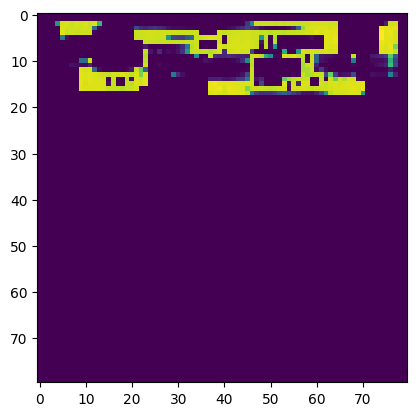

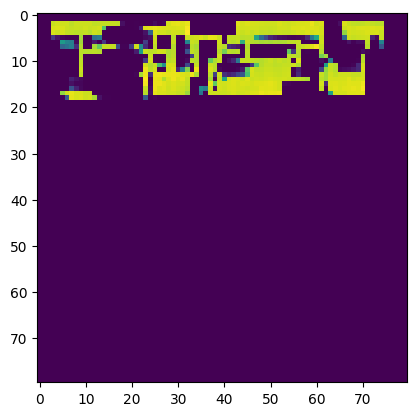

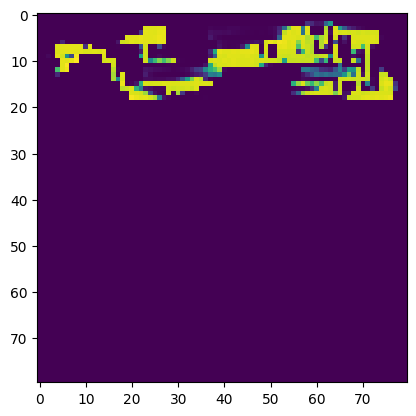

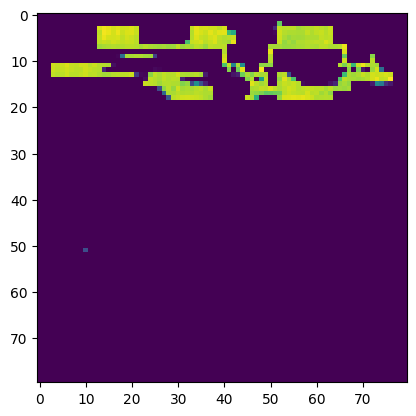

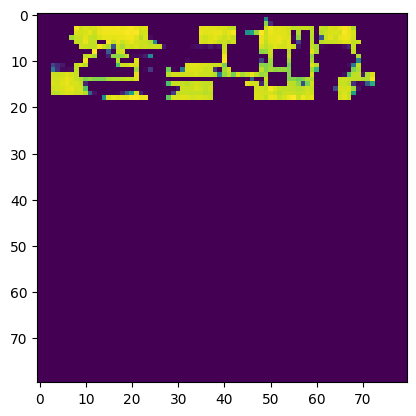

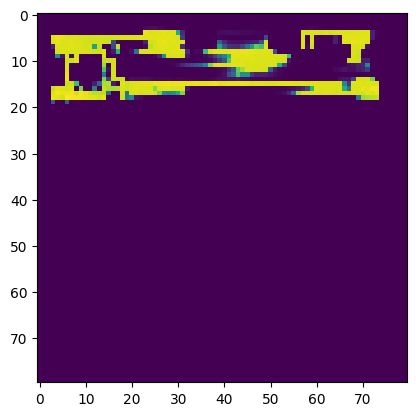

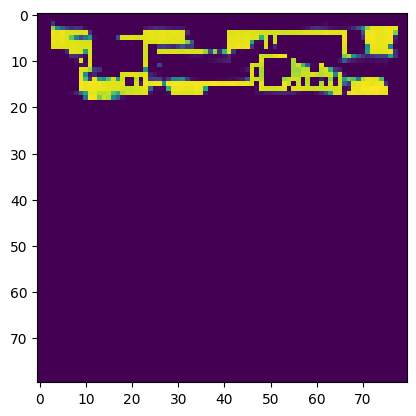

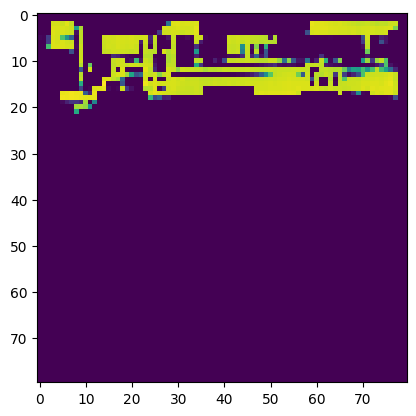

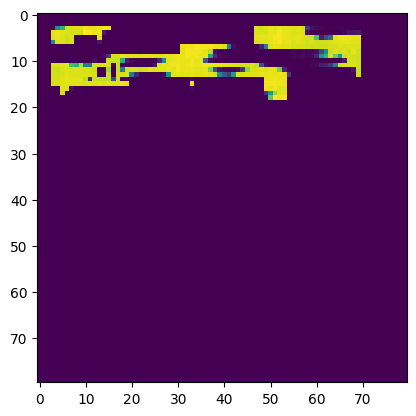

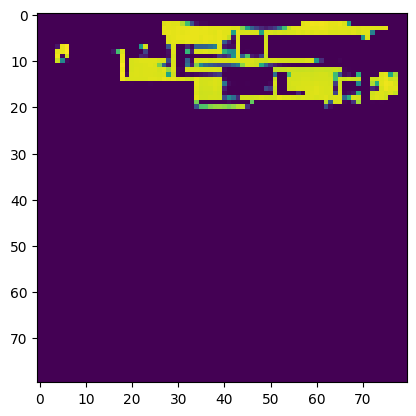

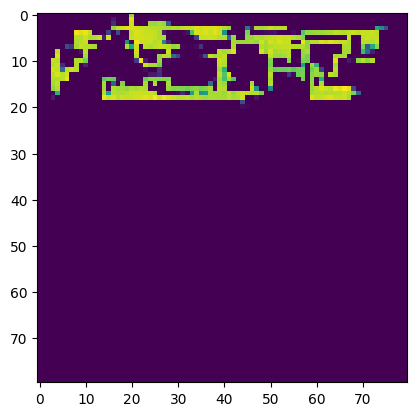

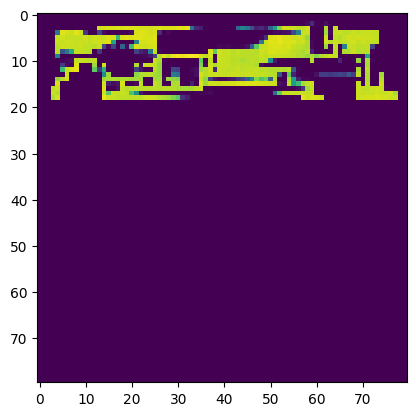

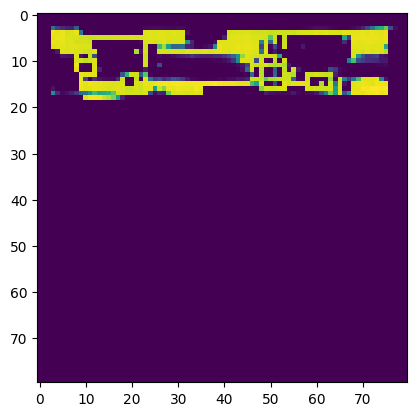

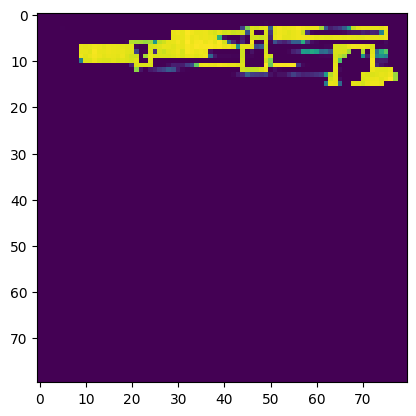

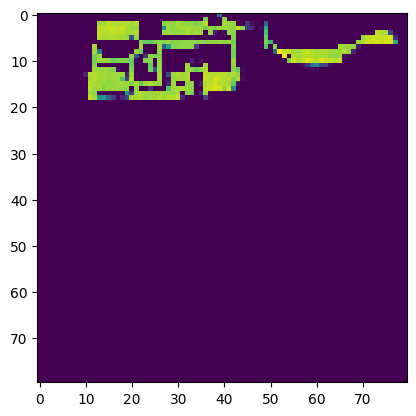

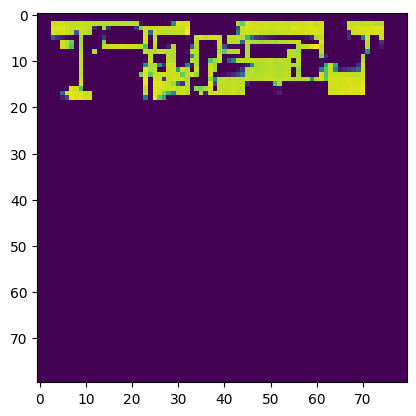

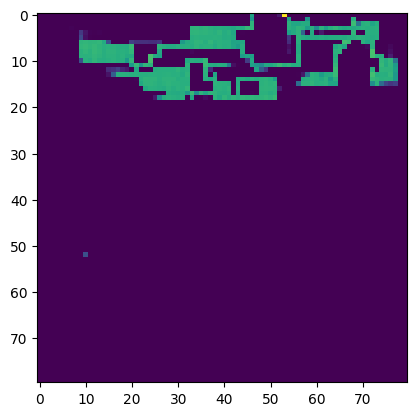

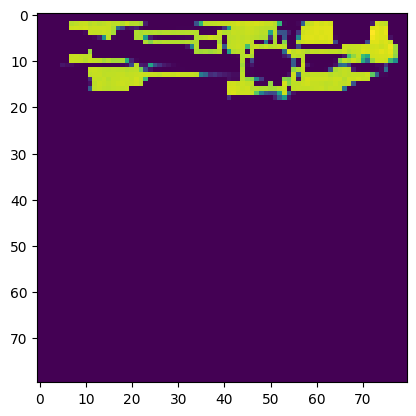

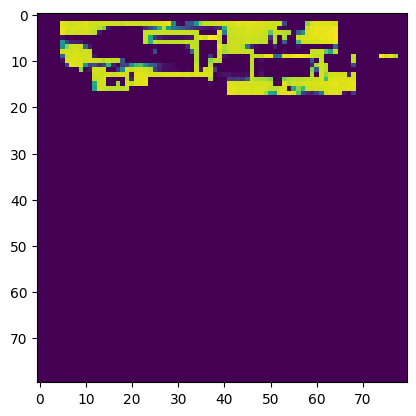

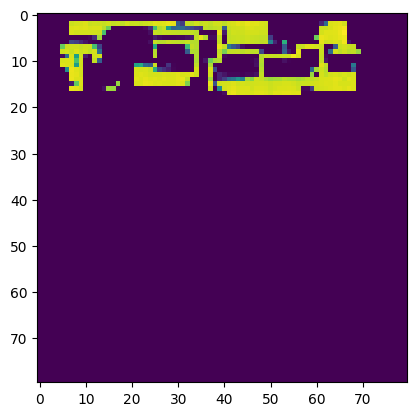

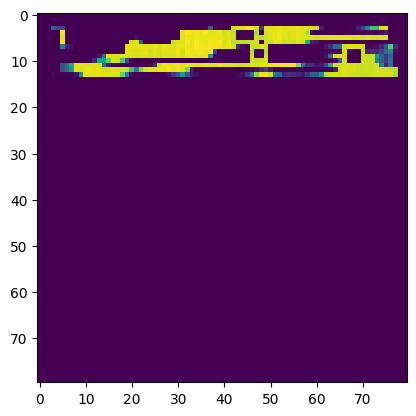

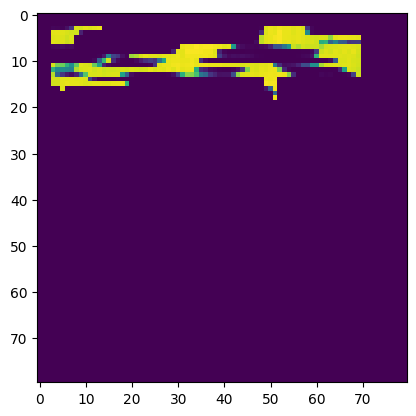

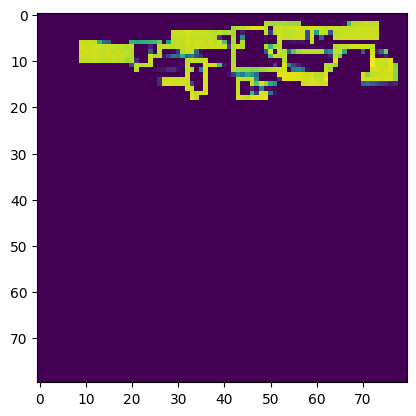

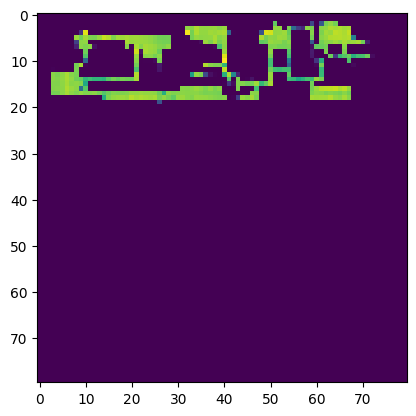

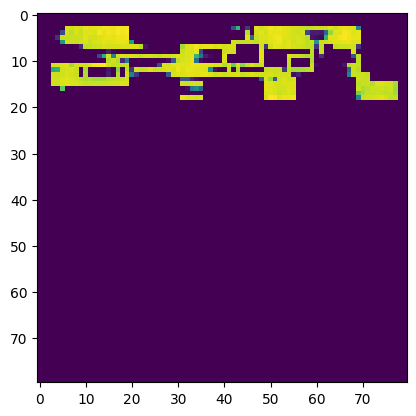

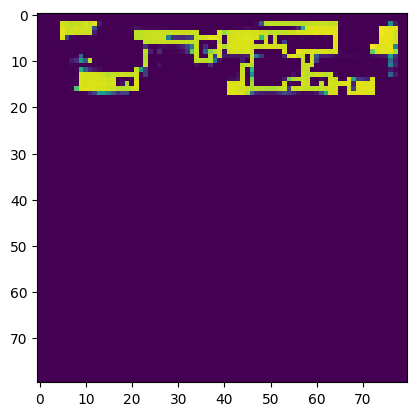

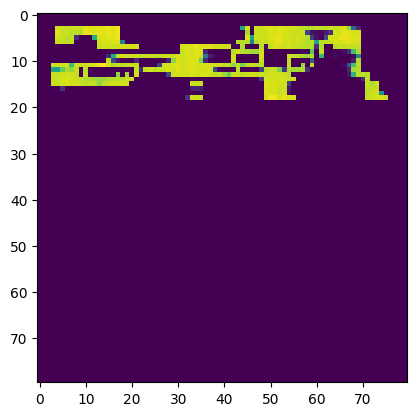

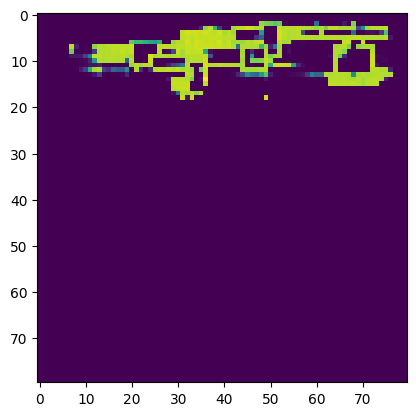

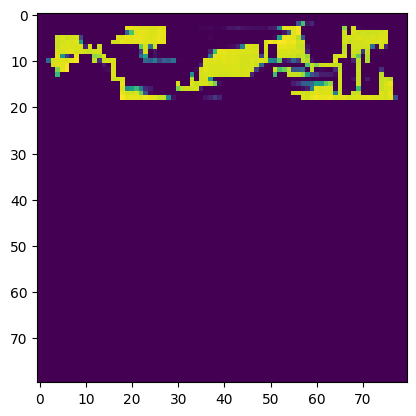

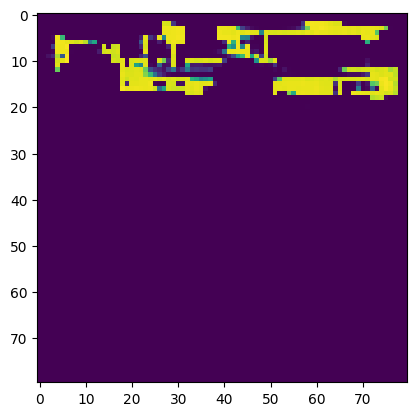

In [12]:

#Show samples
latent_vectors = np.random.normal(0.0, 1.0, [64, 100])
fake_images = generator.predict(latent_vectors)

for i in range(10, 40):
    plt.figure(i)
    plt.imshow(fake_images[i].reshape([80, 80]))

plt.show()

In [13]:
# Save the generator model
generator.save('AdaIN 80x80 Models\\generator_model_20000.h5')

# Save the discriminator model
discriminator.save('AdaIN 80x80 Models\\discriminator_model_20000.h5')

In [5]:
from tensorflow.keras.models import load_model

# Load the generator model
generator = load_model('AdaIN 80x80 Models\\generator_model_20000.h5')

# Load the discriminator model
discriminator = load_model('AdaIN 80x80 Models\\discriminator_model_20000.h5')

C:\Users\basak\anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


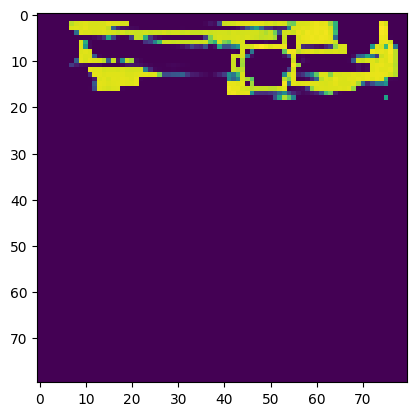

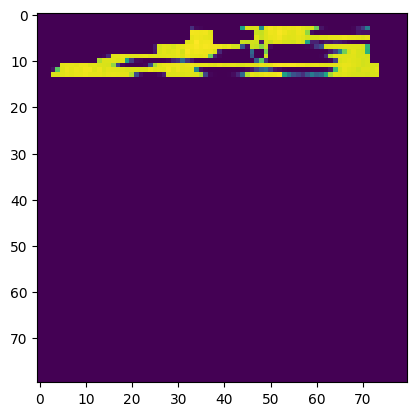

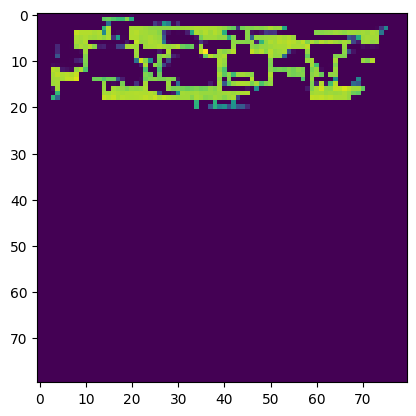

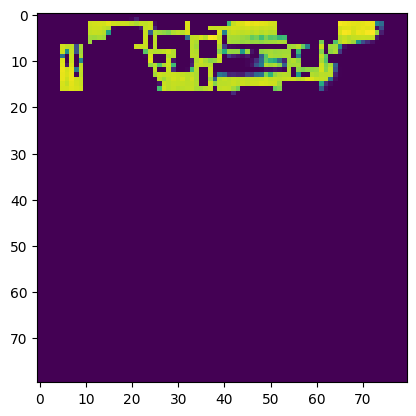

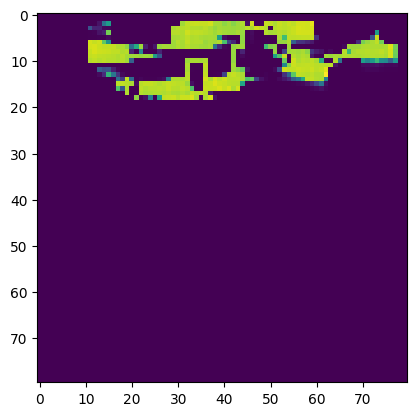

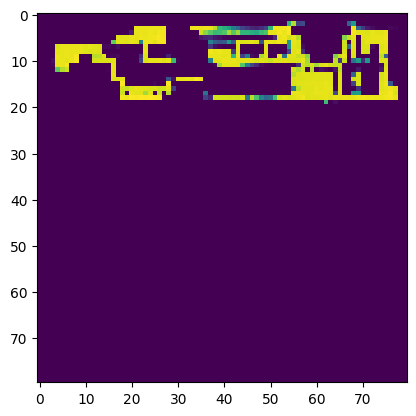

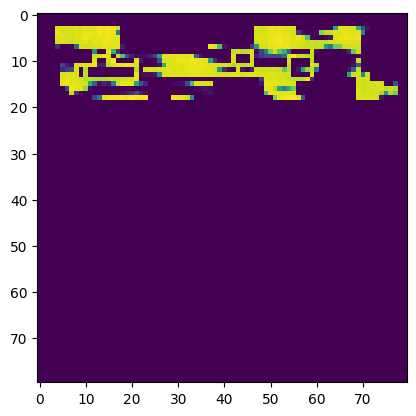

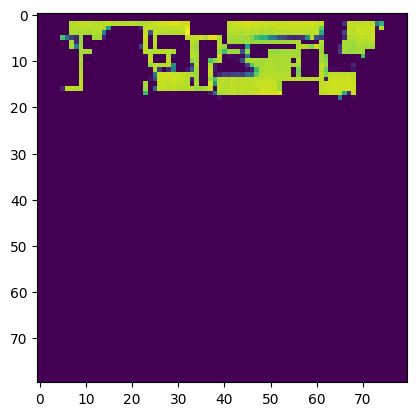

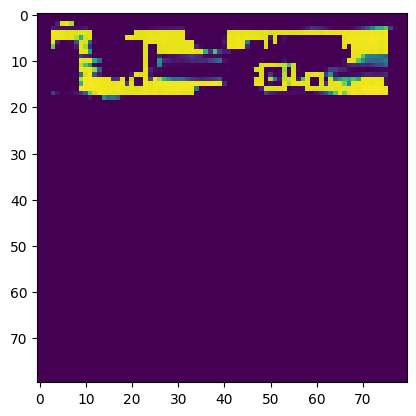

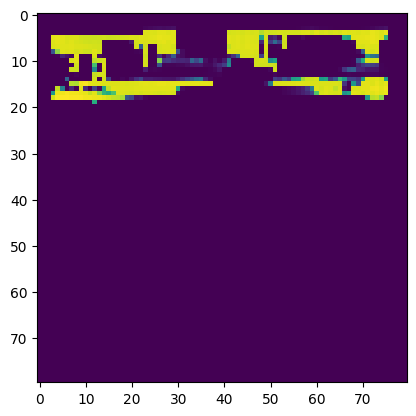

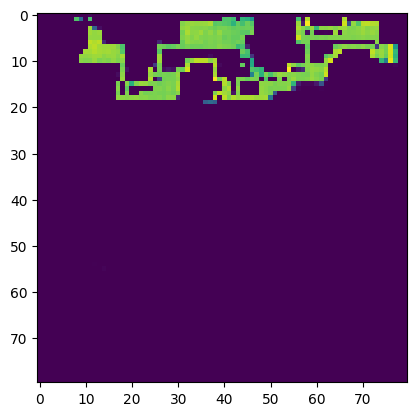

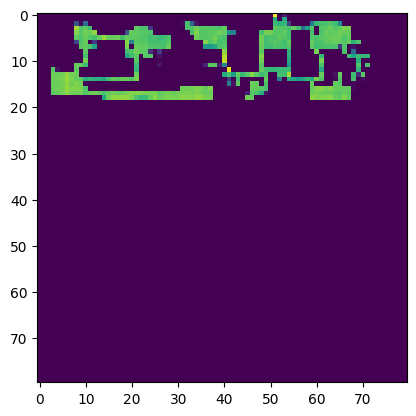

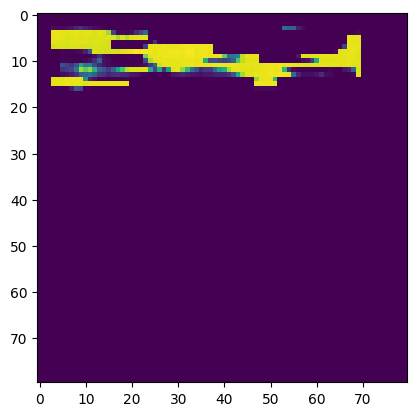

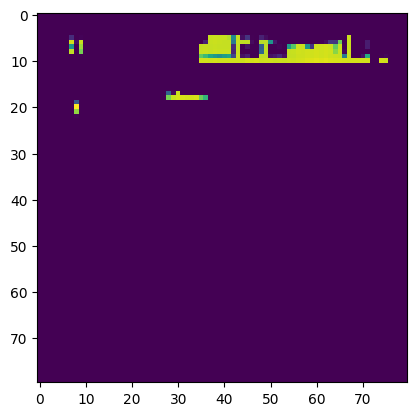

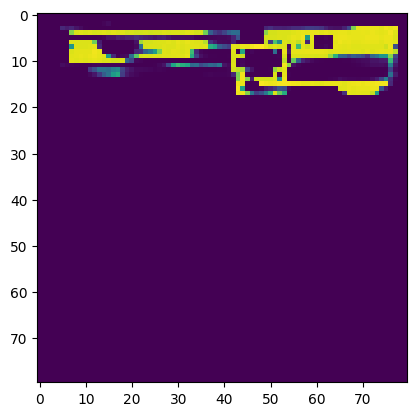

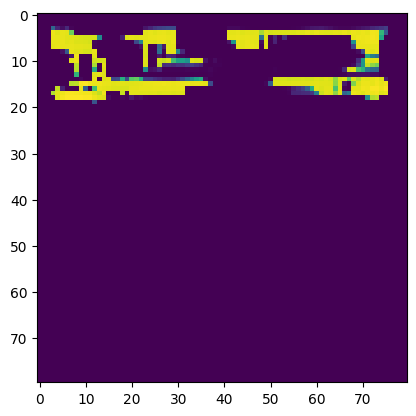

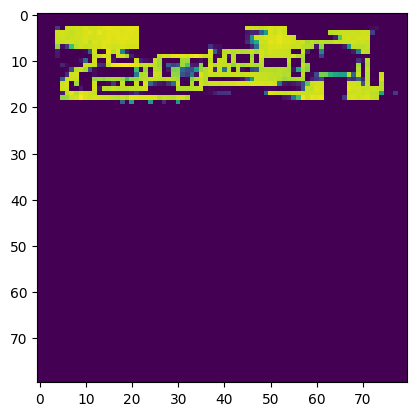

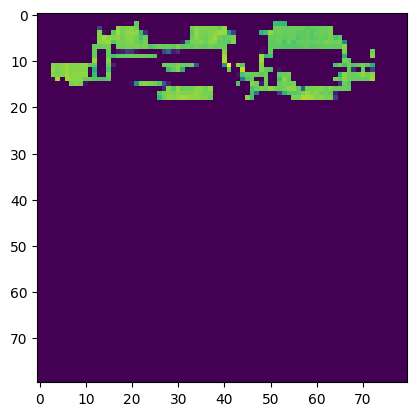

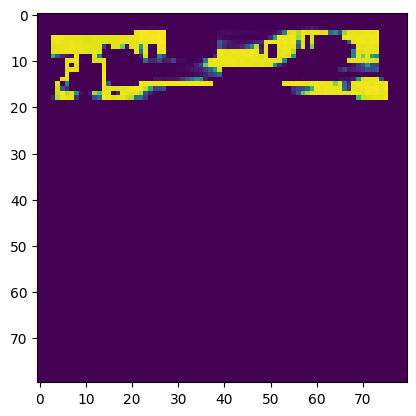

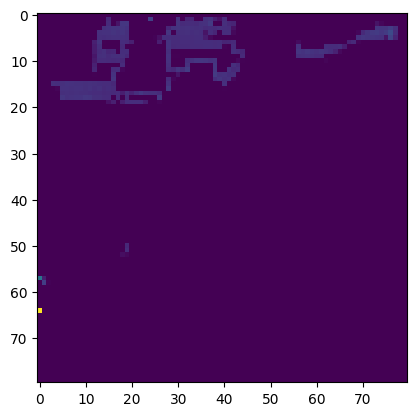

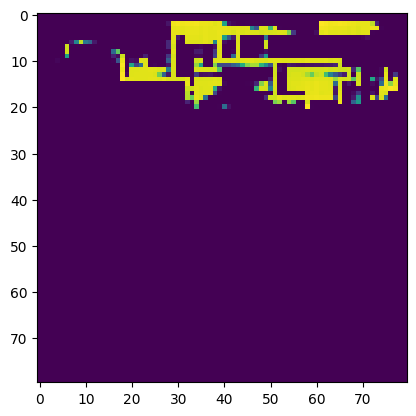

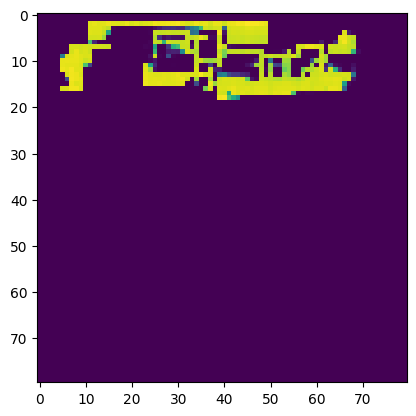

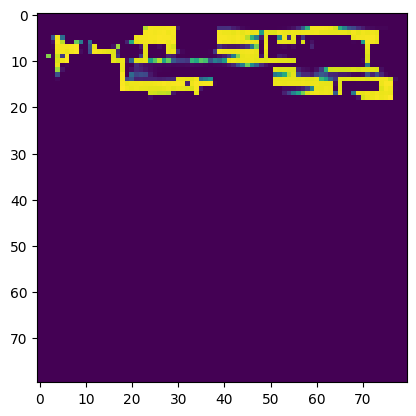

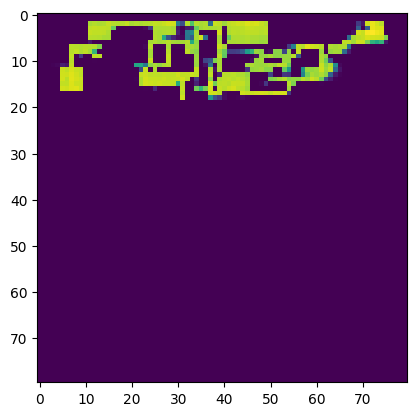

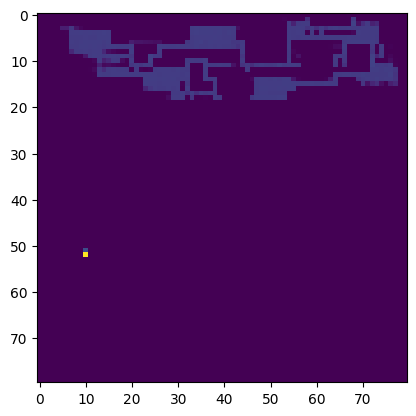

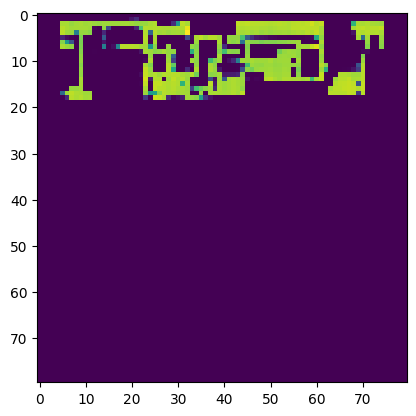

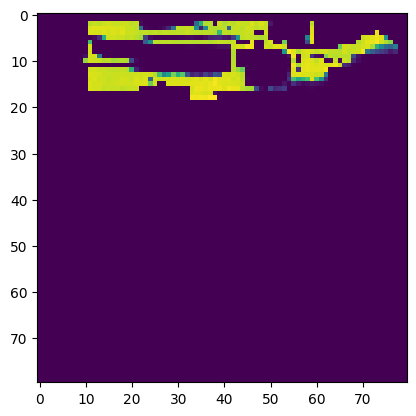

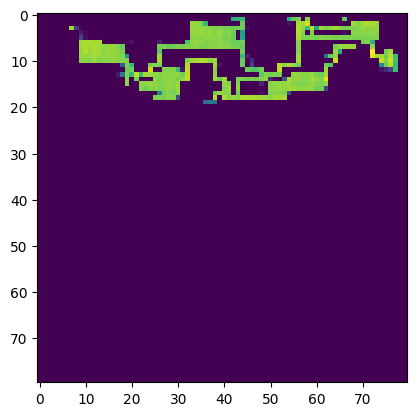

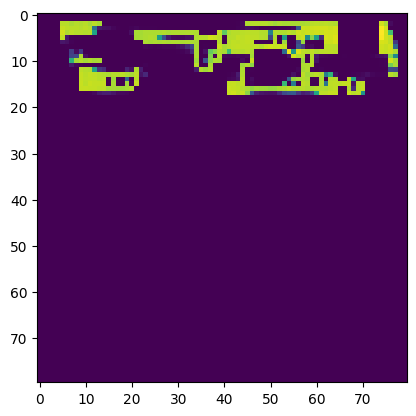

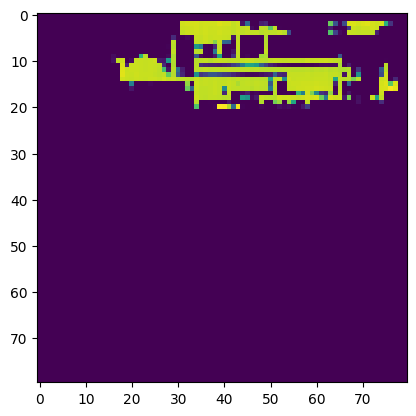

In [6]:

#Show samples
latent_vectors = np.random.normal(0.0, 1.0, [64, 100])
fake_images = generator.predict(latent_vectors)

for i in range(10, 40):
    plt.figure(i)
    plt.imshow(fake_images[i].reshape([80, 80]))

plt.show()